# Example analysis pipeline

## Simple comparison of neural activity during stimulus condition on/off 


Load in relevant local application modules:

In [1]:
import sys
import matplotlib.pyplot as plt

import os
import sys
import numpy as np
import random
from random import uniform
import copy

from types import SimpleNamespace
import inflect

# Local application imports 
from database.db_setup import *
import preprocessing.data_preprocessing.binning as binning
import preprocessing.data_preprocessing.create_vectors_from_time_points as create
import annotation.stimulus_driven_annotation.movies.annotation_utils as utils

Please enter DataJoint username:  root
Please enter DataJoint password:  ···············


Connecting root@localhost:3306


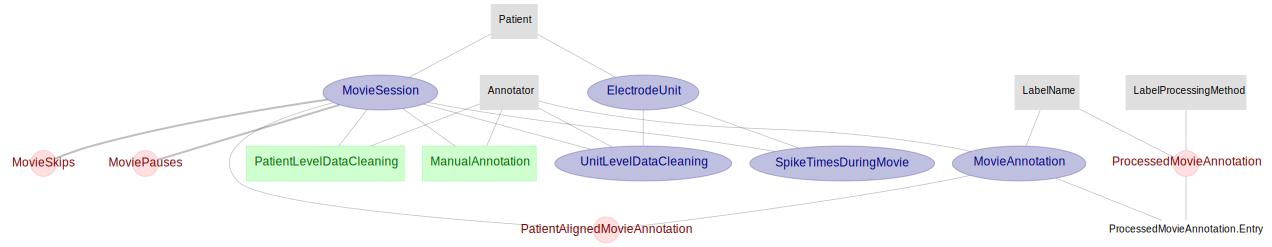

In [2]:
erd = dj.ERD(epi_schema)
erd

Set parameters:

In [3]:
patient_id = 2
session_nr = 1
unit_nr = 1
bin_size = 1000

Get activity from the database, set binning parameters, and bin: 

In [7]:
spike_times = get_spiking_activity(patient_id, session_nr, unit_nr)
spike_times = spike_times / 1000 # convert to milliseconds

exclude_pauses = False
output_edges = True

binned_spikes, edges = binning.bin_spikes(patient_id, session_nr, spike_times, bin_size, exclude_pauses, output_edges) 

Text(0, 0.5, 'binned time (each bin is 1000msec)')

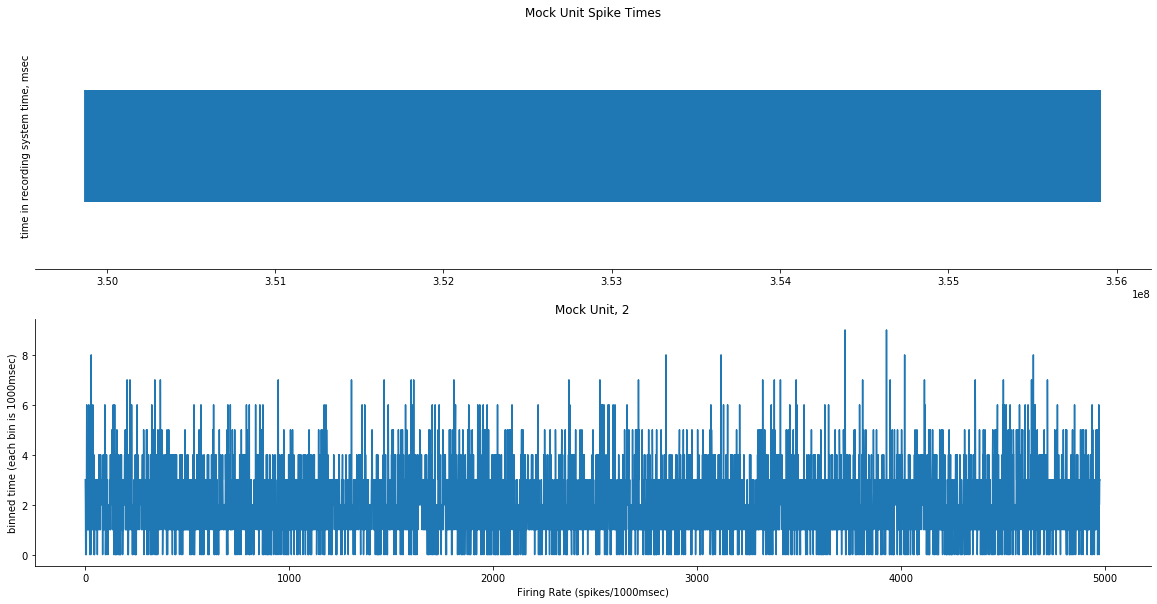

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))

ax1.eventplot(spike_times)
ax1.set_title("Mock Unit Spike Times")
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_yticks([])
ax1.set_ylabel("time in recording system time, msec")

ax2.plot(binned_spikes)
ax2.set_title("Mock Unit, 2")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.set_yticks([])
ax2.set_xlabel("Firing Rate (spikes/1000msec)")
ax2.set_ylabel("binned time (each bin is 1000msec)")

## Using edges outputted above, generate a vector representing when a feature was presented during the stimulus:  

In [12]:
PatientAlignedMovieAnnotation()

annotator_id unique ID for each annotator,label_name label name,annotation_date date of annotation,session_nr session ID,patient_id patient ID,label_in_patient_time label matched to patient time (pts),values list of values that represent label,start_times list of start times of label segments in neural recording time,stop_times list of stop times of label segments in neural recording time,additionl_information
p2,character1,2019-12-12,1,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,character1,2019-12-12,1,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,character1,2019-12-12,1,3,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,character2,2019-10-10,1,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,character2,2019-10-10,1,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,character2,2019-10-10,1,3,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,location1,2020-01-01,1,1,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,location1,2020-01-01,1,2,=BLOB=,=BLOB=,=BLOB=,=BLOB=,
p2,location1,2020-01-01,1,3,=BLOB=,=BLOB=,=BLOB=,=BLOB=,


In [21]:
label_name = "location1"
annotator_id = "p2"
annotation_date = "2020-01-01"

values_local, starts_local, stops_local = get_patient_aligned_annotations(patient_id, label_name, annotator_id, annotation_date)

In [20]:
label_name = "character1"
annotator_id = "p2"
annotation_date = "2019-12-12"

values_char1, starts_char1, stops_char1 = get_patient_aligned_annotations(patient_id, label_name, annotator_id, annotation_date)

In [22]:
character1_binned = create.create_vector_from_start_stop_times_reference(edges, values_char1, starts_char1, stops_char1)
location1_binned = create.create_vector_from_start_stop_times_reference(edges, values_local, starts_local, stops_local)

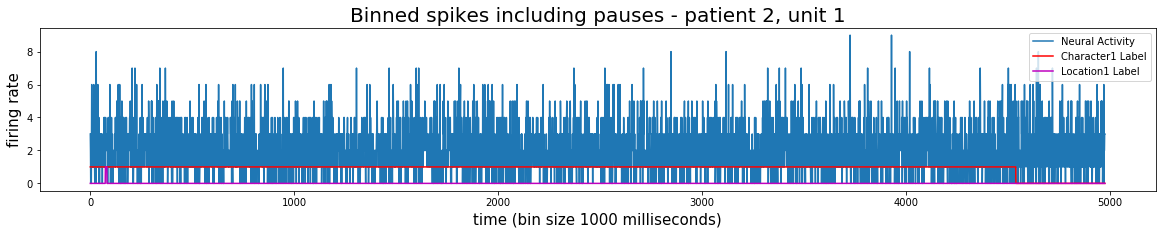

In [25]:
fig = plt.figure(figsize=(20,3))
plt.plot(binned_spikes, label="Neural Activity")
plt.plot(character1_binned, color="r", label="Character1 Label")
plt.plot(location1_binned, color="m", label="Location1 Label")
if exclude_pauses:
    plt.title("Binned spikes excluding pauses - patient {}, unit {}".format(patient_id, unit_nr), fontsize=20)
else:
    plt.title("Binned spikes including pauses - patient {}, unit {}".format(patient_id, unit_nr), fontsize=20)
plt.xlabel("time (bin size {} milliseconds)".format(bin_size), fontsize=15)
plt.ylabel("firing rate", fontsize=15)

plt.legend()

plt.show()

Split activity into groups corresponding to the stimulus values, 

* One: Stimulus-on condition 
* Zero: Stimulus-off condition

In [35]:
char1_splits = utils.split_activity_by_value(binned_spikes, character1_binned)
char1_activity = SimpleNamespace(**char1_splits)
char1_on = char1_activity.one
char1_off = char1_activity.zero

loc1_splits = utils.split_activity_by_value(binned_spikes, location1_binned)
loc1_activity = SimpleNamespace(**loc1_splits)
loc1_on = loc1_activity.one
loc1_off = loc1_activity.zero

In [39]:
print("Firing rates during character 1 on-screen: ", char1_on)
print("Firing rates during character 1 off-screen: ", char1_on)

assert (len(char1_off) + len(char1_on)) == (len(character1_binned))

print("")

print("Firing rates during location 1 on-screen: ", loc1_on)
print("Firing rates during location 1 off-screen: ", loc1_off)

assert (len(loc1_off) + len(loc1_on)) == (len(location1_binned))

Firing rates during character 1 on-screen:  [3 2 0 ... 2 5 1]
Firing rates during character 1 off-screen:  [3 2 0 ... 2 5 1]

Firing rates during location 1 on-screen:  [1 4 3 2 2 2 2 3]
Firing rates during location 1 off-screen:  [3 2 0 ... 2 3 3]


In [40]:
def exact_mc_perm_test(xs, ys, nmc):
    n, k = len(xs), 0
    diff = np.abs(np.mean(xs) - np.mean(ys))
    zs = np.concatenate([xs, ys])
    for j in range(nmc):
        np.random.shuffle(zs)
        k += diff < np.abs(np.mean(zs[:n]) - np.mean(zs[n:]))
    return k / nmc

In [46]:
print(exact_mc_perm_test(loc1_on, loc1_off, 1000))
print(exact_mc_perm_test(char1_on, char1_off, 1000))

0.539
0.148
